### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Add the downloaded notebook (.ipynb file) to the submission zip**.

Make sure you fill in any place that says `YOUR CODE HERE` or "**WRITE YOUR ANSWER IN THIS CELL**", and that no tests fail.  
Write the IDs of all group members in the cell below. Leave any surplus IDs as `""`.

ID1 = ""  
ID2 = ""  


---

![shakespeare](https://i.imgur.com/81YZuel.jpg)

# Generating Shakespeare Using a Character-level Language Model

### From Words to Characters
In the previous two sections we dealt with word-level language models. But looking again at section 2, there is nothing that constraints us to using _words_ as the basic elemnents in our model. The model we analyzed in section 2 could just as well be character-based - just replace "word" with "character", and you are good to go. In this notebook we will train a small character-based language model that will help us generate Shakespearean-like (emphasis on the _like_...) texts.

### Question 3.a
Can you think of an advantage a character-based language model could have over a word-based language model? _(You might find question 2.c useful)_. And what about the other way around: can you think of an advantage a word-based language model could have over a character-based language model?

**WRITE YOUR ANSWER IN THIS CELL**
We think that a character-based language model can be better in languages like Hebrew or German, where each word is a construction of few sub-words. For example the Hebrew word (ובבתיהם) contains 3 meaning units: “in” “their” and “houses”. It is very reasonable to assume that this word won’t appear much at this form, but rather in a few other forms of the word “בית”. Therefore, it will be hard to train word- based model (sparsity), as opposed to char based model.
On the other hand, because in a text there are significantly less words then chars, words based model will have less layers and will work faster. Additionally, it will grasp the semantic better then char-based model, because he will need less layers to connect 2 different words

### Using PyTorch

We'll build our language model using PyTorch. PyTorch is a [very popular](https://thegradient.pub/state-of-ml-frameworks-2019-pytorch-dominates-research-tensorflow-dominates-industry/) open-source machine learning (and deep learning) framework developed by Facebook. In short:

> Pytorch is a Python-based scientific computing package targeted at two sets of audiences:
* A replacement for NumPy to use the power of GPUs
* A deep learning research platform that provides maximum flexibility and speed

To get familiar with PyTorch, check out this [quick tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html). In addition, another imporant difference from numpy is that PyTorch can automatically calculate the gradients needed for backpropagation, as explained [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

### Preparing the Data

Our dataset is a plain text file. For simplicity, we turn any potential unicode characters into plain ASCII by using the `unidecode` package.

In [4]:
import string
import random
import re

import unidecode

all_characters = string.printable
n_characters = len(all_characters)  # our vocabulary size (|V| from the handout)

dataset_as_string = unidecode.unidecode(open('data/shakespeare.txt').read())
n_chars_in_dataset = len(dataset_as_string)
print(f'Total number of characters in our dataset: {n_chars_in_dataset}')

Total number of characters in our dataset: 1115394


To make inputs out of this big string of text, we will split it into chunks.

In [5]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, n_chars_in_dataset - chunk_len)
    end_index = start_index + chunk_len + 1
    return dataset_as_string[start_index:end_index]

print(random_chunk())

in:
And after many scorns, many foul taunts,
They took his head, and on the gates of York
They set the same; and there it doth remain,
The saddest spectacle that e'er I view'd.

EDWARD:
Sweet Duke of York, our prop to lean upon,
Now thou art gone, we have no staff, no stay.
O Clifford, boisterous Clifford! thou hast slain
The flower of Europe for his chivalry;
And treacherously hast thou vanquish'd


### Building Our Model

Our model consists of three main components:

1. [**Embedding**](https://pytorch.org/docs/stable/nn.html#embedding). A mapping between characters and their learned representations ("word vectors") \[correspoding to ${\boldsymbol L}$ in terms of the handout\]
2. [**GRU**](https://pytorch.org/docs/stable/nn.html#gru). \[correspoding to the computation of ${\boldsymbol h}^{(t)}$ in terms of the handout\]
3. **Output Layer**. A feed-forward neural network that transforms a hidden state at a timestep into a probability distribution of the next character. \[correspoding to the computation of $\hat{\boldsymbol y}^{(t)}$ in terms of the handout\] 

### Question 3.b
Complete the implementation of the `forward` method of our model.

In [20]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(OurModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)  # In the terms of the handout, here d = D_h
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_, hidden):
        # General instructions:
        # Pass the embedded input through the GRU and use the output layer to get the next character distribution.
        # return that distribution and the next hidden state.
        # You may need to play around with the dimensions a bit until you get it right. Dimension-induced frustration is good for you!
        # -------------------------
        # YOUR CODE HERE
        input           = self.embedding(input_.view(1, -1))
        output, hidden  = self.gru(input.view(1, 1, -1), hidden)
        output          = self.output_layer(output.view(1, -1))
        # -------------------------
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

### Creating the Training Examples

Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [21]:
# Turn a string into list of longs
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Each training example for our model will be created from a chunk randomly extracted from our shakespeare dataset. For example, if we set our chunk size to be 28, then a randomly extracted chunk could be $\texttt{As deep as that, though true}$. Each training example is of a form $(\textbf{x},\textbf{y})$ where $\textbf{x}$ is all the charecters of the chunk *except the last* and $\textbf{y}$ is all the charecters of the chunk *except the first*. For example, given the chunk above, $\textbf{x}=\texttt{As deep as that, though tru}$ and $\textbf{y}=\texttt{s deep as that, though true}$. At timestep i our input is $\textbf{x}^{(i)}$ and the gold label our model will try to predict is $\textbf{y}^{(i)}$.

In [27]:
def random_training_example():    
    chunk = random_chunk()
    inp = chars_to_tensor(chunk[:-1])
    target = chars_to_tensor(chunk[1:])
    return inp, target

### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

### Training

In [13]:
import torch.nn.functional as F

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = chars_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist =  F.softmax(output / temperature, dim=-1)
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char)

    return predicted

The main training function

In [23]:
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

A helper to print the amount of time passed:

In [24]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {math.floor(s)}s'

In [16]:
# DO NOT DELETE THIS CELL


Define the training parameters, instantiate the model, and start training:

In [25]:
n_iterations = 2000
print_every = 100
plot_every = 10
hidden_size = 100  # (D_h from the handout)
num_layers = 1
lr = 0.005

model = OurModel(n_characters, hidden_size, n_characters, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for iteration in range(1, n_iterations + 1):
    loss = train(*random_training_example())       
    loss_avg += loss

    if iteration % print_every == 0:
        print(f'[time elapsed: {time_since(start)}  ;  iterations: {iteration} ({iteration / n_iterations * 100}%)  ;  loss: {loss:.4}]')
        print(evaluate('Wh', 200), '\n')  # generate text starting with 'Wh'

    if iteration % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time elapsed: 0m 25s  ;  iterations: 100 (5.0%)  ;  loss: 2.175]
Whe you thel an the wil an wor at in im and I you ial thit an walll me gay my o she il dray burich lie th nor stin fared ler you frer, your mane preat s maray und my th weroke as soung ou pase gen porvi 

[time elapsed: 0m 53s  ;  iterations: 200 (10.0%)  ;  loss: 2.05]
Wher, dour prownd enf[ingiled row
To wor let fin dowdge to thof fith were agales?

Seclenging I's hernare come ming mans, I wo gromed,
Mor Ky coof heres and dom eand lut kith in of tow ther?

Mand orngi 

[time elapsed: 1m 20s  ;  iterations: 300 (15.0%)  ;  loss: 1.942]
Whos is cears then gavelves.

LOCUTE:
We hou thoussed, in beppore endangany.

FRCIO:
Hom be low,
Belbare to by am and nald beced the ben is pretret heave oke.

AULE:
Aclend in my ablles Iald is amanely  

[time elapsed: 1m 47s  ;  iterations: 400 (20.0%)  ;  loss: 1.791]
What my have your the kised I not that, the I sherve,
That you sy weed if, coarfter, Sigsir, west cray his have a feer,

### Training Loss

Plotting the the losses that were computed during training can provide a further indication that the network was indeed learning.

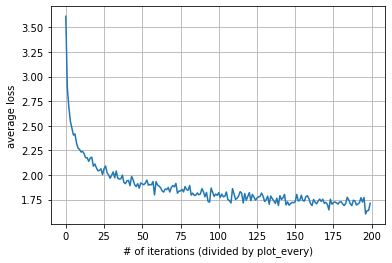

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.grid(True)
plt.xlabel('# of iterations (divided by plot_every)')
plt.ylabel('average loss')
plt.plot(all_losses)

### Evaluating at Different Temperatures
Every time we use the `evaluate` function to generate the distribution of the next character, we don't just use softmax as usual, but we also divide by a `temperature`.  
Let's examine the effect of changing the temperature when generating text using our trained model:

In [29]:
print(evaluate('Th', 400, temperature=0.1))

That the so so so sorrow.

MARIANA:
The so so so so so so so so so so soul'd the for the so some
The so so so so so his death her for the so so so soul'd
The so so so so so so so so so soul'd the so so so some
The so so so so so his death the for the so so so soul'd
The death the so so so so so so so so so some the some
The so his so so so so so so so so so so so so some
The so so so so so so so so 


In [30]:
print(evaluate('Th', 400, temperature=0.5))

That the say this like your bewone
The did compants the for the peers her not honess,
Thou have his celest that stroke in the serve and the so the sten vichless
This beace a couse at that with this so lead of the too master of a some
The so Clipter in my love the for your sore in
Her, dainest of my from he gried in that the deen from
That love see the pealter a presser for the fair falest of thy
sho


In [31]:
print(evaluate('Th', 400, temperature=0.8))  # the default value

That then with lay my for say
Ay, the for life for he ctarry the ere my boot,
Than at done gorsing thee know to morers bent-to his?

CAPULET:
Who the son'd myself so haster when at it say.

PRANIO:
The king Mantreed will bettering broth;
Night gave thinst other priest stranio I love love you know and my love soul'd, I

HENA:
What I fear as brother and as with it the pleforitor'd.
Shall a common: boy


In [32]:
print(evaluate('Th', 400, temperature=1))

That And as your sight
Talicies love Is it shall villess friin his filled all.

HENGRIAS:
He's fet at verve of than you desoul gives.

THOMPRONENI:
My have is tish'd, angir--whis now he mine is else.
So his have more untow a grout-do so'll'd in
the madge sayeld man themTy bore
whisy to--twaule.

HENRY ANNE:
Why your grait; faith nellow tonguest then?

COMINIUS:
For you batherd it in was to returpst 


In [33]:
print(evaluate('Th', 400, temperature=1.5))

Thilve a to ningetion'
Weatherean thif her o, andy inteer!
A ei, Ae-gritosed Itlego dry dnart;
for crobficative, Rome, falliag my ma?
Good'd,
For he so Cumlar waor meptisabours to,ture: dOut'ty?
The patherAh y laindd'll enomps thee; yo, undirs,
Firle? O aploye. Of hopporm.

RILA AI:
I'll Dres: wisof?' wondrenkoflocsits,, foave with uft washil
grow.
By keen seit.

YORK:
Mo'th have eviced?

thinwerut,


### Question 3.c
How does the value of `temperature` affect the properties of the generated text?
Specifically address the process of sampling a character from the next character distribution, and the effect `temperature` has on it.

**WRITE YOUR ANSWER IN THIS CELL**
Temperature affects the softmax output;
High temperature will result with more evenly distributed probabilities for the tokens whereas lower temperature will result with less evenly distributed probability and more towards the tokens with the original higher softmax probabilities. 
Higher temperature yields more diverse and random text, with more mistakes.
Lower temperature yields more predictable and repetitive text with same high probability tokens appearing more. 